In [2]:
## read the data
import scipy.io
data = scipy.io.loadmat('/Users/jinyanwei/Desktop/BP_Model/Data/Cuffless_BP_Estimation/part_1.mat')

In [64]:
fs =125 # Sample rate in Hz

import scipy.signal as signal
def chebyshev_filter(signal):
    # Define the filter order and cutoff frequency
    order = 4
    cutoff_freq = 20  # Cutoff frequency in Hz
    # Create the Chebyshev low-pass filter
    b, a = signal.cheby1(order, 0.5, cutoff_freq / (fs / 2), 'low', analog=False)
    return signal.lfilter(b, a, signal)

from scipy.signal import butter, filtfilt
def butter_filter(signal):
    fs = 125  # Sample rate
    cutoff = 5  # Cutoff frequency in Hz
    # Design the Butterworth low-pass filter
    nyquist = 0.5 * fs
    cutoff_norm = cutoff / nyquist
    b, a = butter(4, cutoff_norm, btype='low')
    return filtfilt(b, a, signal)

import numpy as np
def straighten_ecg(ecg_signal):
    detrended_ecg = np.subtract(ecg_signal, np.mean(ecg_signal))
    return detrended_ecg
    
import numpy as np
def normalize_sinal(ppg):
# Assuming ppg_signal and ecg_signal are your original PPG and ECG signals
    ppg_min = np.min(ppg)
    ppg_max = np.max(ppg)
    normalized_ppg = (ppg - ppg_min) / (ppg_max - ppg_min)
    return normalized_ppg
def standard_signal(bp): 
    return (bp - np.mean(bp)) / np.std(bp)
def inverse_standard_signal(bp_ori, bp_est):
    mean = np.mean(bp_ori)
    std = np.std(bp_ori)
    return (bp_est * std) + mean

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def align_ppgbp_segment(ppg_signal, bp_signal1, bp_signal2, ecg_signal, show=0): ## ppg_signal = ppg_normalized, bp_signal = bp_normalized, ecg_signal = ecg_normalized; get ppg_aligned, bp_aligned
    ppg_peaks, _ = find_peaks(ppg_signal, height=0.5)  # Adjust the height threshold as needed
    bp_peaks, _ = find_peaks(bp_signal1, height=0.4)
    ecg_peaks, _ = find_peaks(ecg_signal, height=0.65)
    #print(f'ppg peaks: {len(ppg_peaks)} {ppg_peaks}')
    #print(f'ecg peaks: {len(ecg_peaks)} {ecg_peaks}')

    first_ecg_peak = ecg_peaks[0]
    #print(f'first ecg peak: {first_ecg_peak}')
    indices_ppg = np.argwhere(ppg_peaks[:10] > first_ecg_peak)
    first_ppg_peak = ppg_peaks[int(indices_ppg[0])]
    #print(f'first ppg peak: {first_ppg_peak}')
    indices_bp = np.argwhere(bp_peaks[:10] > first_ecg_peak)
    first_bp_peak = bp_peaks[int(indices_bp[0])]
    #print(f'first bp peak: {first_bp_peak}')
    ppg_bp_peaks_subtraction = abs(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(ppg_bp_peaks_subtraction)
    distance_ppgbp = np.bincount(ppg_bp_peaks_subtraction).argmax()
    #print(move_distance)
    #print(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(f'distance:{distance_ppgbp}')
    if first_bp_peak > first_ppg_peak:
        bp_aligned = bp_signal1[distance_ppgbp:]
        bp_ori_aligned = bp_signal2[distance_ppgbp:]
        ppg_aligned = ppg_signal
    elif first_bp_peak < first_ppg_peak:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal[distance_ppgbp:]
    else:
        bp_aligned = bp_signal1
        bp_ori_aligned = bp_signal2
        ppg_aligned = ppg_signal
    #print(f'ppg len: {len(ppg_aligned)}')
    #print(f'bp len: {len(bp_aligned)}')
    min_len = min(len(bp_aligned), len(ppg_aligned))
    ppg_aligned = ppg_aligned[:min_len]
    bp_aligned = bp_aligned[:min_len]
    bp_ori_aligned = bp_ori_aligned[:min_len]
    ecg_aligned = ecg_signal[:min_len]
    #print(ecg_aligned)
    ppg_segmented = ppg_aligned[:first_ecg_peak-5]
    bp_segmented = bp_aligned[:first_ecg_peak-5]
    bp_ori_segmented = bp_ori_aligned[:first_ecg_peak-5]
    ecg_segmented = ecg_aligned[:first_ecg_peak-5]

    for ecgi in range(len(ecg_peaks)-1):
        one_ppg_peak, _ = find_peaks(ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5], height=0.5)
        #print(ecg_peaks[ecgi], one_ppg_peak)
        if len(one_ppg_peak) == 1:
            ppg_segmented = np.concatenate((ppg_segmented, ppg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_segmented = np.concatenate((bp_segmented, bp_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            bp_ori_segmented = np.concatenate((bp_ori_segmented, bp_ori_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))
            ecg_segmented = np.concatenate((ecg_segmented, ecg_aligned[ecg_peaks[ecgi]-5:ecg_peaks[ecgi + 1]-5]))

    if show == 1:
        plt.figure(figsize=(30, 6))
        plt.plot(ppg_signal, label='PPG')
        plt.plot(bp_signal1, label='BP')
        plt.plot(ecg_signal, label='ECG')
        plt.scatter(ppg_peaks, ppg_signal[ppg_peaks], color='c', marker='o', label='Aligned PPG Peaks')
        plt.scatter(bp_peaks, bp_signal1[bp_peaks], color='orange', marker='o', label='Aligned BP Peaks')
        plt.scatter(ecg_peaks, ecg_signal[ecg_peaks], color='green', marker='o', label='Aligned BP Peaks')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(30, 6))
        plt.plot(ppg_segmented, label='PPG')
        plt.plot(bp_segmented, label='BP')
        plt.plot(ecg_segmented, label='ECG')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

    return ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented

import numpy as np
def get_feautres(ppg_signal, bp_signal1, bp_signal2, ecg_signal):
    ori_ecg_peaks, _ = find_peaks(ecg_signal)
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    #print(f'r_peaks: {len(r_peaks)} {r_peaks}')
    r_peak_amplitudes = (ecg_signal[r_peaks]).tolist()
    r_peak_amplitudes = r_peak_amplitudes[:-1]
    #print(f'r_peak_amplitudes: {len(r_peak_amplitudes)} {r_peak_amplitudes}')
    r_peak_intervals = (np.diff(r_peaks) / fs).tolist()
    #print(f'r_peak_intervals: {len(r_peak_intervals)} {r_peak_intervals}')
    # calculate low peak, s-peak
    low_peak_amplitudes, r_to_low_peak_amplitudes, s_peak_amplitudes= [], [], []
    low_peaks, s_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        low_peak_amplitude = np.min(ecg_signal[r_peak:next_r_peak])
        r_to_low_peak_amplitude = ecg_signal[r_peak]-low_peak_amplitude
        low_peak_amplitudes.append(low_peak_amplitude)
        r_to_low_peak_amplitudes.append(r_to_low_peak_amplitude)
        low_peak = r_peak + np.argmin(ecg_signal[r_peak:next_r_peak])
        low_peaks.append(low_peak)
        s_peak_amplitude = np.min(ecg_signal[r_peak:low_peak])
        s_peak_amplitudes.append(s_peak_amplitude)
        s_peak = r_peak + np.argmin(ecg_signal[r_peak:low_peak])
        s_peaks.append(s_peak)   
    #print(f'low peaks: {len(low_peaks)} {low_peaks}')  
    #print(f's peaks: {len(s_peaks)} {s_peaks}')  
    # T-Wave Amplitude Calculation
    r_peaks = np.insert(r_peaks, 0, 0) #the first t-peak is before the R-peak
    t_wave_amplitudes, q_wave_amplitudes = [], []
    t_peaks, q_peaks = [], []
    for i in range(len(r_peaks) - 1):
        r_peak = r_peaks[i]
        next_r_peak = r_peaks[i + 1]
        t_wave_amplitude = np.max(ecg_signal[r_peak:next_r_peak])
        t_wave_amplitudes.append(t_wave_amplitude)
        t_peak = r_peak + np.argmax(ecg_signal[r_peak:next_r_peak])
        t_peaks.append(t_peak)
        q_wave_amplitude = np.min(ecg_signal[t_peak:next_r_peak])
        q_wave_amplitudes.append(q_wave_amplitude)
        q_peak = r_peak + np.argmin(ecg_signal[t_peak:next_r_peak])
        q_peaks.append(q_peak)

    t_wave_amplitudes = t_wave_amplitudes[:-1]
    q_wave_amplitudes = q_wave_amplitudes[:-1]
    #print(f't peaks: {len(t_peaks)} {t_peaks}')  
    #print(f'q peaks: {len(q_peaks)} {q_peaks}')  
    
    # QRS interval
    r_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])
    qrs_intervals = []
    for i in range(len(r_peaks)-1):
        qrs_interval = (ecg_signal[s_peaks[i]] - ecg_signal[q_peaks[i]]) / fs
        qrs_intervals.append(abs(qrs_interval))
    #print(f'qrs_intervals: {len(qrs_intervals)} {qrs_intervals}')  

    # get ppg features:
    ppg_pulses, bp_pulses, bp_ori_pulses = [], [], []
    for i in range(len(r_peaks)-1):
        ppg_pulse = ppg_signal[r_peaks[i]:r_peaks[i+1]]
        bp_pulse = bp_signal1[r_peaks[i]:r_peaks[i+1]]
        bp_ori_pulse = bp_signal2[r_peaks[i]:r_peaks[i+1]]
        ppg_pulses.append(ppg_pulse)
        bp_pulses.append(bp_pulse)
        bp_ori_pulses.append(bp_ori_pulse)
    #print(f'bp pulses: {bp_pulses}')
    ppg_pulse_amplitude = [np.max(pulse) - np.min(pulse) for pulse in ppg_pulses]
    ppg_pulse_width = [pulse.shape[0]/fs for pulse in ppg_pulses]
    ppg_high_to_low_interval = [np.argmin(pulse)/fs for pulse in ppg_pulses]
    ppg_slope_change_std = [np.std(np.diff(pulse)) for pulse in ppg_pulses]

    sbp = [np.max(pulse) for pulse in bp_pulses]
    dbp = [np.min(pulse) for pulse in bp_pulses]
    sbp_ori = [np.max(pulse) for pulse in bp_ori_pulses]
    dbp_ori = [np.min(pulse) for pulse in bp_ori_pulses]
    
    return sbp, dbp, sbp_ori, dbp_ori, ppg_pulse_amplitude, ppg_pulse_width, ppg_high_to_low_interval, ppg_slope_change_std, t_wave_amplitudes, q_wave_amplitudes, r_peak_amplitudes, s_peak_amplitudes, low_peak_amplitudes, qrs_intervals, r_to_low_peak_amplitudes, r_peak_intervals

import matplotlib.pyplot as plt
def show_one(signal1):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1)
    return plt.show()
def show_two(signal1, signal2):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.legend()
    return plt.show()
def show_three(signal1, signal2, signal3):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.plot(signal3, label='3')
    plt.legend()
    return plt.show()

In [180]:
## Can't be used data: patient_unable = []
## Some wrongs data: patient_better_dont_ues = [2]
## data['p'].shape:(1, 1000); patient_data = data['p'][0,patient_num], shape:(3, points)
patient_data = data['p'][0,18]
ppg_ori = patient_data[0]
bp_ori = patient_data[1]
ecg_ori = patient_data[2]

ecg_detrened = straighten_ecg(ecg_ori)
ppg_normalized = normalize_sinal(ppg_ori)
bp_standarded = bp_ori / 250
ecg_normalized = normalize_sinal(ecg_detrened)
ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented = align_ppgbp_segment(ppg_signal = ppg_normalized, bp_signal1 = bp_standarded, bp_signal2 = bp_ori, ecg_signal = ecg_normalized, show=0)
bps_features = get_feautres(ppg_segmented, bp_segmented, bp_ori_segmented, ecg_segmented)
sbp = np.array(bps_features[0])
dbp = np.array(bps_features[1])
sbp_ori = np.array(bps_features[2])
dbp_ori = np.array(bps_features[3])
features = np.array(bps_features[4:])
np.max(features), features.shape, sbp.shape, dbp.shape,sbp_ori.shape, dbp_ori.shape,features[:, :300].shape, sbp[:300].shape

(1.0, (12, 804), (804,), (804,), (804,), (804,), (12, 300), (300,))

torch.Size([747, 4, 12]) torch.Size([51, 4, 12]) torch.Size([747, 1]) torch.Size([51, 1]) torch.Size([51, 1])
Epoch [10/200], Loss: 0.08233271539211273
Epoch [20/200], Loss: 0.0014137157704681158
Epoch [30/200], Loss: 0.005509641021490097
Epoch [40/200], Loss: 0.001954016275703907
Epoch [50/200], Loss: 0.001075726468116045
Epoch [60/200], Loss: 0.0008068694151006639
Epoch [70/200], Loss: 0.0005531013594008982
Epoch [80/200], Loss: 0.000591113930568099
Epoch [90/200], Loss: 0.0005443189875222743
Epoch [100/200], Loss: 0.0005421487148851156
Epoch [110/200], Loss: 0.0005408074939623475
Epoch [120/200], Loss: 0.0005374802276492119
Epoch [130/200], Loss: 0.0005361179355531931
Epoch [140/200], Loss: 0.0005348477861844003
Epoch [150/200], Loss: 0.0005334554007276893
Epoch [160/200], Loss: 0.0005321089993230999
Epoch [170/200], Loss: 0.0005307788960635662
Epoch [180/200], Loss: 0.0005294426809996367
Epoch [190/200], Loss: 0.000528103846590966
Epoch [200/200], Loss: 0.0005267664091661572
Test L

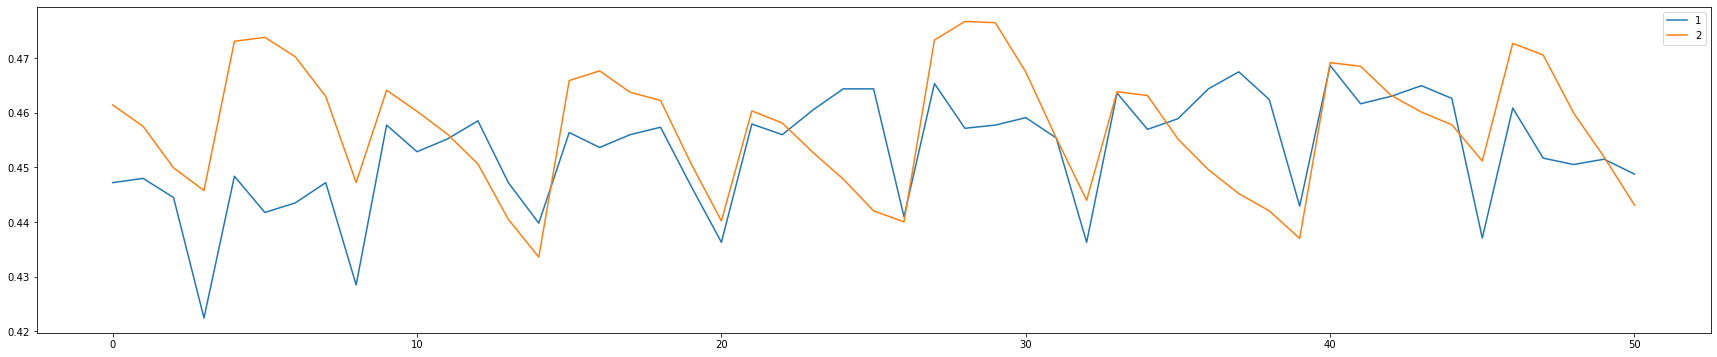

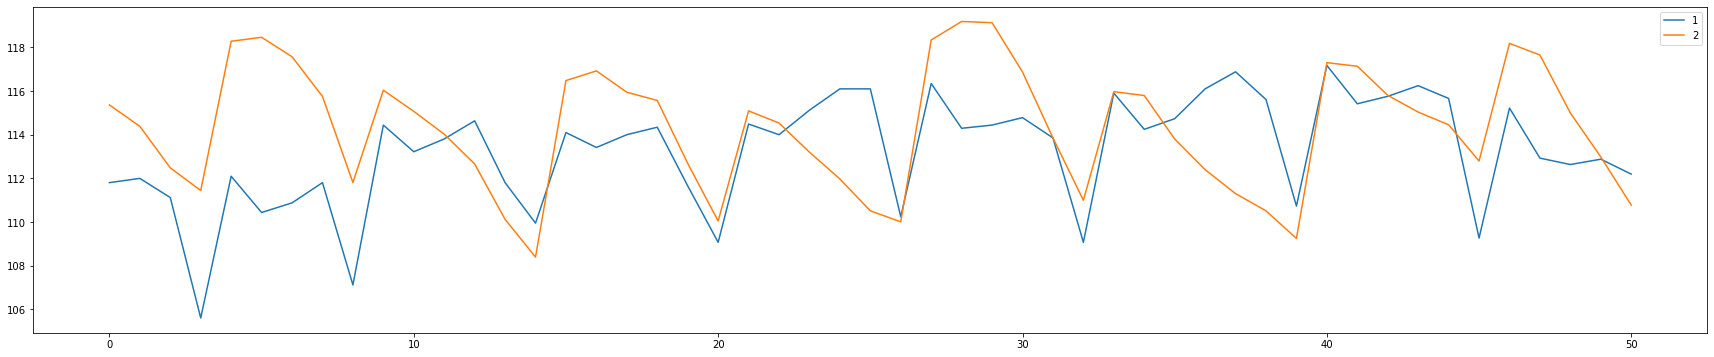

In [181]:
# reshape the data
import torch
time_step = 4
X_train_noshape = torch.tensor(features[:, :750])
y_train_noshape = torch.tensor(sbp[:750])
X_test_noshape = torch.tensor(features[:, 750:])
y_test_noshape = torch.tensor(sbp[750:])
y_test_ori_noshape = torch.tensor(sbp_ori[750:])
train_num_samples = X_train_noshape.shape[1] - time_step + 1
X_train = torch.zeros((train_num_samples, time_step, X_train_noshape.shape[0]))
y_train = torch.zeros((train_num_samples, 1))
for i in range(train_num_samples):
    X_train[i] = X_train_noshape[:, i:i+time_step].T
    y_train[i] = y_train_noshape[i+time_step-1]
test_num_samples = X_test_noshape.shape[1] - time_step + 1
X_test = torch.zeros((test_num_samples, time_step, X_test_noshape.shape[0]))
y_test = torch.zeros((test_num_samples, 1))
y_test_ori = torch.zeros((test_num_samples, 1))
for i in range(test_num_samples):
    X_test[i] = X_test_noshape[:, i:i+time_step].T
    y_test[i] = y_test_noshape[i+time_step-1]
    y_test_ori[i] = y_test_ori_noshape[i+time_step-1]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_test_ori.shape)

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out[:, -1, :])
        return output

# Create an instance of the LSTM model
model = LSTMModel(input_size = 12, hidden_size = 64, output_size = 1)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)   
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_ori = y_pred * 250
    test_loss = criterion(y_pred, y_test)
    print(f"Test Loss: {test_loss.item()}")
mae = mean_absolute_error(np.array(y_test_ori), np.array(y_pred_ori))
rmse = np.sqrt(mean_squared_error(np.array(y_test_ori), np.array(y_pred_ori)))
print("MAE:", mae)
print("RMSE:", rmse)
show_two(y_test, y_pred)
show_two(y_test_ori, y_pred_ori)